(quickstart)=
# Quickstart

Welcome to the Quickstart guide! This section will guide you through setting up BayesBay, defining a simple model, and running your first MCMC inversion. Before starting, ensure that BayesBay is installed (see our [Installation Guide](../installation)). The imports needed for this tutorial are below.

In [110]:
import bayesbay as bb

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 1. Problem Definition

In this example, we will use BayesBay to infer the posterior distribution $p(m \mid d) \propto p(m) p(d \mid m)$, where both the model $m$ and the observed data $d$ are real numbers. (In other words, we will use a zeroth-order polynomial model.) Specifically, we consider the case where $m_{\text{true}} = 10$ and $d \sim \mathcal{N}(m_{\text{true}}, \sigma^2)$, where $\sigma = 0.5$ denotes the data noise standard deviation. We will use a uniform prior $p(m) = \frac{1}{b - a} = 0.1$, defined over the interval $a = 5$ to $b = 15$.




In [57]:
m_true = 10
sigma_true = 0.5
d = np.random.normal(m_true, sigma_true)


To solve the Bayesian inverse problem of inferring $m$ from the observations, we need to define:

* A [Parameterization](bayesbay.parameterization.Parameterization) instance, encapsulating the prior probability.
* A [LogLikelihood](bayesbay.likelihood.LogLikelihood) instance, enabling evaluation of model goodness at each Markov chain iteration.

We will implement the latter through a *forward function*, which returns data predictions $d_{\text{pred}}$ at each Markov chain iteration, and a [Target](bayesbay.likelihood.Target), a Python object designed to store all information about the observed data.

## 2. Parameterizing the Inverse Problem

### **2.1 Prior Distribution**

First, let's define the uniform probability distribution mentioned earlier. This is readily done through the class [UniformPrior](../api/generated/bayesbay.prior.UniformPrior).

In [58]:
m_prior = bb.prior.UniformPrior(name="m", vmin=5, vmax=15, perturb_std=0.5)

Through the variable `m_prior`, we can verify that we have indeed implemented the prior distribution we wished. For example:

In [59]:
print(f'a = {m_prior.vmin}')
print(f'b = {m_prior.vmax}')
print(f'p(m=5) = {round(np.exp(m_prior.log_prior(5)), 10)}')
print(f'p(m=10) = {round(np.exp(m_prior.log_prior(10)), 10)}')
print(f'p(m=15) = {round(np.exp(m_prior.log_prior(10)), 10)}')
print(f'p(m=20) = {round(np.exp(m_prior.log_prior(20)), 10)}')

a = 5
b = 15
p(m=5) = 0.1
p(m=10) = 0.1
p(m=15) = 0.1
p(m=20) = 0.0


```{note}
Different prior distributions can be implemented through the classes available in the module [bayesbay.prior](../api/api_standard_prior). Each of these classes requires the user to define `perturb_std`, the standard deviation $\theta$ of the Gaussian used to perturb the considered parameter at each Markov chain iteration. Specifically, if the parameter $m$ has a current value $x$ at a given iteration, the proposed value $x'$ is drawn from the distribution $x' \sim \mathcal{N}(x, \theta^2)$.

### **2.2 Parameter Space**

The prior distribution defined above should be used to create what we call a [ParameterSpace](../api/generated/bayesbay.parameterization.ParameterSpace). A `ParameterSpace` is a specialized container that not only groups the inversion free parameters (each of which is characterized by a prior distribution) but also determines their dimensionality. In this case, the dimensionality of $m$ will be fixed and equal to 1.

In [60]:
param_space = bb.parameterization.ParameterSpace(
    name="m_space", 
    n_dimensions=1, 
    parameters=[m_prior], 
)
print(param_space)

m_space(parameters=[UniformPrior(name=m, position=None, vmin=5, vmax=15, perturb_std=0.5, perturb_std_birth=None)], n_dimensions=1)


````{note}
Trans-dimensional models with a number of dimensions between 1 and 100 can be defined using the following syntax:

```python
param_space = bb.parameterization.ParameterSpace(
    name="m_space",
    n_dimensions=None,
    n_dimension_min=1,
    n_dimensions_max=100,
    parameters=[m_prior],
)
```

Note the use of `n_dimensions=None`, indicating that the number of dimensions is unknown.
````

### **2.3 Parameterization**

One or more instances of `ParameterSpace` should be used to define a [Parameterization](bayesbay.parameterization.Parameterization). The main purpose of `Parameterization` is to aggregate all model parameters from all specified instances of `ParameterSpace`. (Note that different instances of `ParameterSpace` can have different dimensionality.)

In [61]:
parameterization = bb.parameterization.Parameterization(param_space)
print(parameterization)

Parameterization([m_space(parameters=[UniformPrior(name=m, position=None, vmin=5, vmax=15, perturb_std=0.5, perturb_std_birth=None)], n_dimensions=1)])


Important for testing and debugging your forward functions (more shortly!), a `Parameterization` instance also allows for drawing random deviates from the prior. These are generated in the form of a BayesBay [State](bayesbay.State), described next.

### **2.4 State**
A `State` is a Python `dataclass` containing all numerical information about the proposed model at each Markov chain iteration.

In [62]:
state = parameterization.initialize()
print(state)

State(param_values={'m_space': ParameterSpaceState(n_dimensions=1, param_values={'m': array([6.63815295])}, cache={})}, temperature=1, cache={}, extra_storage={})


Note how `state` is organized. It resembles a Python dictionary where each key is the name of a `ParameterSpace` instance (in this case we only have one, `'m_space'`). For each `ParameterSpace` instance, numerical values are assigned to its free parameters (in this case, only `'m'`). 

````{admonition} Tip
:class: tip
A `State` instance contains information about the temperature of the Markov chain in which it is generated. This defaults to one but can be modified to achieve advanced [sampling criteria](../api/api_standard_samplers). Additionally, users can cache any data they wish via the `State.save_to_cache()` method and retrieve it through `State.load_from_cache()`. For example:

```python
# Save
my_result = np.random.randn() # Any data type works
state.save_to_cache(name='my_result_name', value=my_result)

# Load
my_result = state.load_from_cache(name='my_result_name')
```

This feature is especially useful within a forward function, allowing users to reuse, in the next iteration, results from computationally intensive operations without recalculating them from scratch.
````

## 3. Defining the Likelihood

### **3.1 Forward Function**

We can now define the forward function that will return the predicted data given the proposed state at each Markov chain iteration. In this case, the forward function is very simple: we only need to retrieve $m$ from the proposed state and return it.

In [63]:
def fwd_function(state: bb.State) -> np.ndarray:
    m = state["m_space"]["m"]
    return m

To verify that the above works, we can write, for example,

In [64]:
print(f'd_pred: {fwd_function(state)}')
print(f'd_obs - d_pred: {d - fwd_function(state)}')

d_pred: [6.63815295]
d_obs - d_pred: [3.23408096]


### **3.2 Target**

The final step before initializing a [LogLikelihood](bayesbay.likelihood.LogLikelihood) instance is to create a [Target](bayesbay.likelihood.Target): a specialized container for storing our data along with any information about data noise.

In [71]:
target = bb.likelihood.Target(
    name="my_target", 
    dobs=d, 
    covariance_mat_inv=1/sigma_true**2
)
print(target)

Target(name='my_target, dobs=ndarray of shape (), is_hierarchical=False, covariance_mat_inv=4.0)


````{note}
We assume here that the noise properties are known by specifying the inverse of the data covariance matrix, `covariance_mat_inv`. Treating the data noise as unknown is also possible, as illustrated in several examples in our documentation. (The simplest example is arguably [Polynomial Fitting: Part II](hierarchical_linregr).)
````

### **3.3 LogLikelihood**

Having defined a forward function and a `Target`, we can use them to initialize a [LogLikelihood](bayesbay.likelihood.LogLikelihood) instance:

In [73]:
log_likelihood = bb.likelihood.LogLikelihood(targets=target, fwd_functions=fwd_function)
print(log_likelihood)

LogLikelihood(targets=[Target(name='my_target, dobs=ndarray of shape (), is_hierarchical=False, covariance_mat_inv=4.0)], fwd_functions=['fwd_function'])


````{note}
Setting up a joint inversion of multiple data sets is straightforward in BayesBay. For example, consider the case where you have two different data sets, stored in `target_1` and `target_2`, each associated with a distinct forward function, `fwd_func_1` and `fwd_func_2`. Then you can simply write:

```python
log_likelihood = bb.likelihood.LogLikelihood(
            targets=[target_1, target_2], 
            fwd_functions=[fwd_func_1, fwd_func_2]
            )
```

````

````{admonition} Tip
:class: tip
In general, when initialized through a forward function and a `Target`, `LogLikelihood` will compute, at each Markov chain iteration, the log of the likelihood

$$
p(\mathbf{d}|\mathbf{m}) = \frac{1}{\sqrt{(2\pi)^n |\mathbf{C}_d|}} \ \exp \left\{\frac{-\Phi(\mathbf{m})}{2} \right\},
$$

where $n$ denotes the size of the data vector, $\mathbf{C}_d$ the data covariance matrix, and

$$
\Phi(\mathbf{m}) = \left[ \mathbf{g}(\mathbf{m}) - \mathbf{d} \right]^T \mathbf{C}_d^{-1} \left[ \mathbf{g}(\mathbf{m}) - \mathbf{d} \right]
$$

is the Mahalanobis distance between predictions $\mathbf{g}(\mathbf{m})$ and observations.

However, a `LogLikelihood` instance can also be initialized by passing a log-likelihood function directly:

```python
log_likelihood = bb.likelihood.LogLikelihood(log_like_func=my_func)
```

````

## 4. Posterior Sampling

Everything is now in place to sample the posterior. To do so, initialize a [BayesianInversion](bayesbay.BayesianInversion) instance using the previously defined `parameterization` and `log_likelihood` while specifying the desired number of Markov chains. The Bayesian sampling is then run through the method `BayesianInversion.run()`, where you can specify the number of iterations (including the number of burn-in iterations) and the interval between model saves.

In [97]:
inversion = bb.BayesianInversion(
    log_likelihood=log_likelihood, 
    parameterization=parameterization, 
    n_chains=10
)
inversion.run(
    n_iterations=50_000, 
    burnin_iterations=5_000, 
    save_every=50, 
    verbose=False, 
)
for chain in inversion.chains:
    chain.print_statistics()

Chain ID: 0
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 35132/50000 (70.26 %)
PARTIAL ACCEPTANCE RATES:
	ParamSpacePerturbation(param_space_name=m_space):
		ParamPerturbation(m_space.m): 35132.00/50000.00 (70.26%)
Chain ID: 1
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 35302/50000 (70.60 %)
PARTIAL ACCEPTANCE RATES:
	ParamSpacePerturbation(param_space_name=m_space):
		ParamPerturbation(m_space.m): 35302.00/50000.00 (70.60%)
Chain ID: 2
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 35253/50000 (70.51 %)
PARTIAL ACCEPTANCE RATES:
	ParamSpacePerturbation(param_space_name=m_space):
		ParamPerturbation(m_space.m): 35253.00/50000.00 (70.51%)
Chain ID: 3
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 35206/50000 (70.41 %)
PARTIAL ACCEPTANCE RATES:
	ParamSpacePerturbation(param_space_name=m_space):
		ParamPerturbation(m_space.m): 35206.00/50000.00 (70.41%)
Chain ID: 4
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 35207/50000 (70.41 %)
PARTIAL ACC

````{note}
By default, when using multiple Markov chains in the sampling process, parallel computing is enabled automatically, with one job assigned per Markov chain (handled through the [Joblib](https://joblib.readthedocs.io/en/stable/) Python library). If the number of Markov chains exceeds the available CPUs, no issues arise&mdash;the primary effect is an increase in total runtime compared to scenarios with enough CPUs for each chain. 

If you wish to specify the exact number of jobs, you can do so by passing keyword arguments to `parallel_config` within `BayesianInversion.run()`. For example, to run 5 parallel jobs, you would write:

```python
inversion.run(
    n_iterations=50_000, 
    burnin_iterations=5_000, 
    save_every=50, 
    verbose=False, 
    parallel_config=dict(n_jobs=5)
)
```

For more details on the keyword arguments available in `parallel_config`, refer to [joblib.Parallel](https://joblib.readthedocs.io/en/stable/generated/joblib.Parallel.html#joblib.Parallel).

````

## **4.1 Retrieving the results**

To retrieve the results, simply write:

In [98]:
results = inversion.get_results(concatenate_chains=True)

print(f'`results` is a dictionary: {results.keys()}')
print(f'results["m_space.m"] is a list of length {len(results["m_space.m"])}')
print(f'results["my_target.dpred"] is a list of length {len(results["my_target.dpred"])}')

`results` is a dictionary: dict_keys(['m_space.m', 'my_target.dpred'])
results["m_space.m"] is a list of length 9000
results["my_target.dpred"] is a list of length 9000


As you can see above, the retrieved results are in the form of a Python dictionary. In this example, we have used one free parameter, which we named `m`, associated with the parameter space `m_space`. Samples of `m` are accessed by writing `results["m_space.m"]`. The second key in the dictionary refers to the data predictions (as returned by our `fwd_function`) linked to our `Target` instance, which we named `my_target`. Additional entries would of course appear in the retrieved dictionary of samples if we had used more free parameters, instances of `ParameterSpace`, or instances of `Target`.

Also note that both `results["m_space.m"]` and `results["my_target.dpred"]` are lists of 9,000 entries, one for each saved sample. (We used 10 chains, each running for 50,000 iterations, and saved one sample every 50 iterations after a burn-in period of 5,000 iterations, giving a total of $\frac{10 \times (50000 - 5000)}{50} = 9000$ saved samples.)

````{tip}
Note that, in this case, each entry in the predicted data vector is identical to the corresponding entry in the sampled model parameter. This can be verified by writing:

```python
np.all(results["m_space.m"] == results["my_target.dpred"])
>>> True
```

This occurs because our model is a zeroth-order polynomial. While this redundancy is unusual, we could have avoided saving the predicted data by specifying `save_dpred=False` when initialising `BayesianInversion`:

```python
bb.BayesianInversion(
    ...,
    save_dpred=False
)
```

````

### **4.2 Plotting**

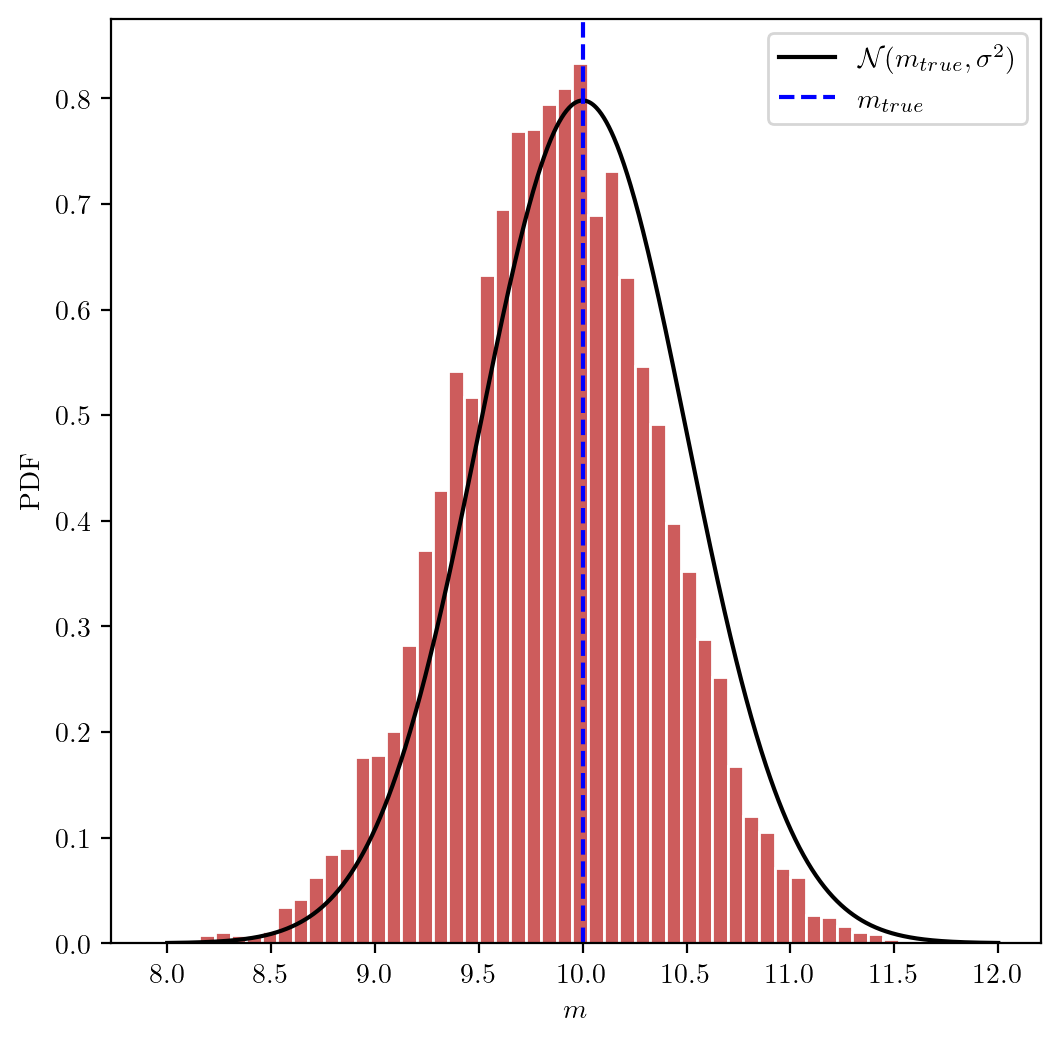

In [117]:


m_samples = np.array(results["m_space.m"])

x = np.linspace(m_true - 4*sigma_true, m_true + 4*sigma_true, 1000)
pdf = norm.pdf(x, loc=m_true, scale=sigma_true)

fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
ax.plot(x, pdf, label=r'$\mathcal{N}(m_{true}, \sigma^2)$', color='k')
ax.hist(m_samples, bins=50, color='indianred', ec='w', density=True)
ax.axvline(x=m_true, color='b', linestyle='--', label=r'$m_{true}$')
ax.legend()
ax.set_xlabel('$m$')
ax.set_ylabel('PDF')
plt.show()